# Objective

Combine centroids found from each crop in this proof-of-concept zoom test and investigate the success of this experiment.

# Result

The centroids found from each crop came together very cleanly. This entire process (auto-generating zoomed-in crops, getting the crops annotated, processing annotation data for each image to get consensus annotations, and adding these consensus annotations back to the parent image) has resulted in a **91% detection rate**. Compare with detection rates of 46% and 56% respectively for the non-inverted and inverted full 700 X 450 pixel image.

# Next step
Clean up code from these zooming + stitching notebooks and add to the pipeline.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load in centroids from the parent image (with crop regions blacked out)

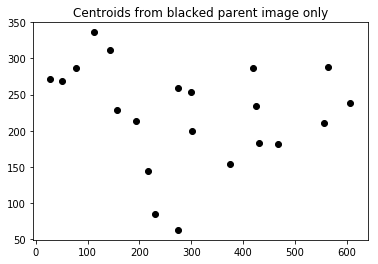

In [2]:
coords_blacked = np.asarray(pd.read_csv('smfish_blacked_coords.csv'))
for coord in coords_blacked:
    plt.scatter(coord[0], 450-coord[1], color = 'black')
plt.title('Centroids from blacked parent image only')
plt.show()

### Load in centroids from individual crops

In the below plot, all centroids from a given individual crop are of the same color.

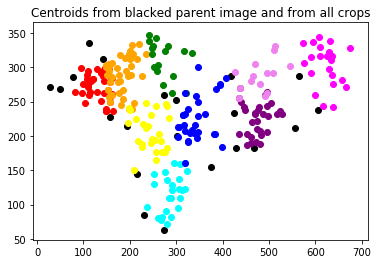

In [3]:
total = []
for coord in coords_blacked:
    plt.scatter(coord[0], 450-coord[1], color = 'black')
    total.append([coord[0], 450-coord[1]])

colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'violet', 'magenta']    
for i in range(9):
    coords = np.asarray(pd.read_csv('smfish_' + str(i) + '_coords.csv'))
    stats = np.asarray(pd.read_csv('smfish_' + str(i) + '.csv', header = None))
    xmin = stats[0][0]
    ymin = stats[2][0]
    ymax = stats[3][0]
    height = ymax - ymin
    zoom_factor = stats[4][0]

    refit = []
    for coord in coords:
        x = coord[0]/zoom_factor + xmin
        y = height - coord[1]/zoom_factor + ymin
        refit.append([x, y])
        total.append([x, y])
    refit = np.asarray(refit)

    for coord in refit:
        plt.scatter(coord[0], coord[1], color = colors[i])

plt.title('Centroids from blacked parent image and from all crops')
plt.show()

### All found centroids vs. ground truth

Visually, all found centroids are very close to ground truth.

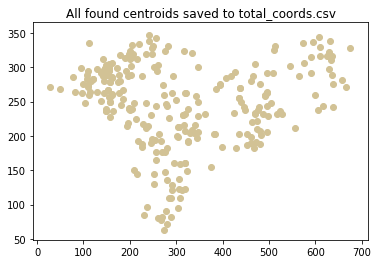

In [4]:
total = np.asarray(total)
np.savetxt('total_coords.csv', total, delimiter=",", comments='', header = "centroid_x,centroid_y")

coords_total = np.asarray(pd.read_csv('total_coords.csv'))
for coord in coords_total:
    plt.scatter(coord[0], coord[1], color = '#d2c295')
    
plt.title('All found centroids saved to total_coords.csv')
plt.show()

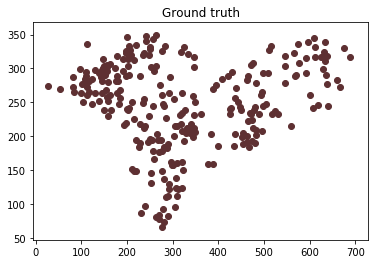

In [5]:
ground_truth = np.asarray(pd.read_csv('700.csv'))
for coord in ground_truth:
    plt.scatter(coord[0], coord[1], color = '#5e3032')
    
plt.title('Ground truth')
plt.show()

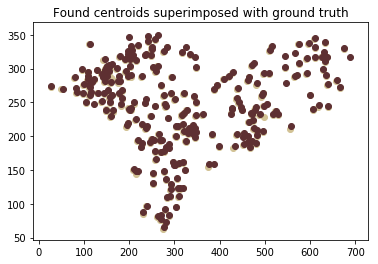

In [11]:
for coord in coords_total:
    plt.scatter(coord[0], coord[1], color = '#d2c295')
for coord in ground_truth:
    plt.scatter(coord[0], coord[1], color = '#5e3032')
plt.title('Found centroids superimposed with ground truth')
plt.show()

### Metric of success: detection rate

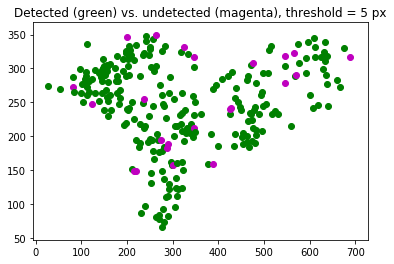

detected / total = 245 / 268 = 0.91


In [18]:
from sklearn.neighbors import KDTree 

def get_nnd(coord, kdt):
    dist, ind = kdt.query([coord], k=2)
    return dist[0][0]

detected = 0
kdt = KDTree(total, leaf_size=2, metric='euclidean')
threshold = 5
for coord in ground_truth:
    nnd = get_nnd(coord, kdt)
    if nnd <= threshold:
        plt.scatter(coord[0], coord[1], facecolors = 'g')
        detected += 1
    else:
        plt.scatter(coord[0], coord[1], facecolors = 'm')
plt.title('Detected (green) vs. undetected (magenta), threshold = ' + str(threshold) + ' px')
plt.show()
print('detected / total = ' + str(detected) + ' / ' + str(len(ground_truth)) + ' = ' + str(round(float(detected)/len(ground_truth), 2)))